## Notebook that compare different atmospheric density models 
- Poliastro exponential model: an approximation, which as we can observe is very far from the more complex model at altitudes around 500km (difference order of magnitude: e15)
- Coe76 model extracted from Poliastro (standard US model, static, does not depend on time)
- ATMOS library (but does not go too far in time)
- New model taken from literature depending on solar activity data

In [2]:
import numpy as np
import sys
from typing import Tuple, Callable

from astropy import units as u
from astropy.time import Time, TimeDelta
from poliastro.bodies import Earth

from poliastro.constants import rho0_earth, H0_earth, J2000
from poliastro.earth.atmosphere import COESA76

from pyatmos import coesa76

from datetime import datetime
from dateutil.relativedelta import relativedelta

from astropy.coordinates import (
    GCRS,
    ITRS,
    CartesianRepresentation,
    SphericalRepresentation,
)

sys.path.insert(0, "../")
from digital_twin.constants import earth_R

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime

sys.path.insert(0, "../")
from digital_twin.plotting import plot_1d, find_x_scale, plot_1d_multiple

The EOP file 'finals2000A.all' in /Users/mathildesimoni/src/iers/ is already the latest.
The Leap Second file 'Leap_Second.dat' in /Users/mathildesimoni/src/iers/ is already the latest.


In [3]:
# EARTH ATMOSPHERE CONSTANTS for the simple exponential atmosphere model
rho0 = rho0_earth.to(u.kg / u.km**3)  # (kg/km^3)
H0 = H0_earth.to(u.km)  # (km)

# COMPLEX ATMOSPHERIC MODEL
atmosphere_model = COESA76()

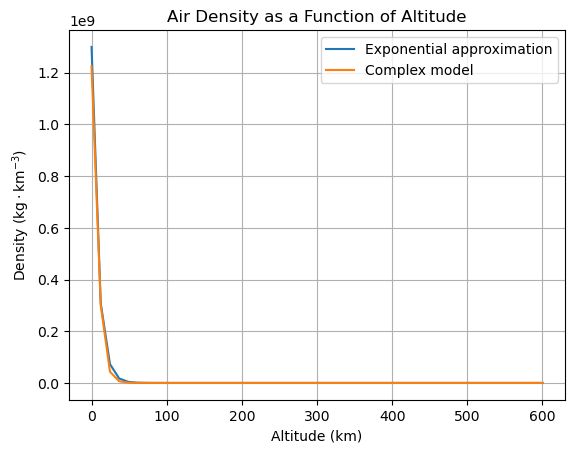

In [11]:
x = np.linspace(0, 600, 50)

y_1 = rho0.value * np.exp(-(x / H0.value))
y_2 = []
for xi in x:
    y_2.append(atmosphere_model.density(xi * u.km).to_value(u.kg / u.km**3))
y_2 = np.array(y_2)

plt.figure()
plt.title(r"Air Density as a Function of Altitude")
plt.plot(x, y_1, label="Exponential approximation")
plt.plot(x, y_2, label="Complex model")
plt.legend()
plt.xlabel(r"Altitude (km)")
# plt.ylabel(r"Density ($kg.km^(-3)$)")
plt.ylabel(r"Density ($\mathrm{kg \cdot km^{-3}}$)")
plt.grid()
plt.show()

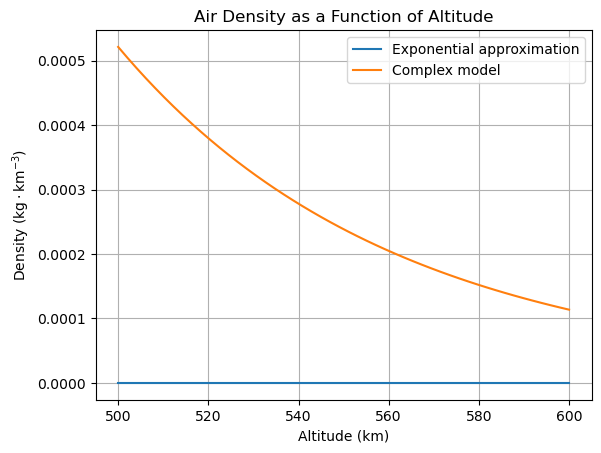

Density at 550 km (kg/m^3):  5.212859332411656e-13
Density at 550 km (kg/km^3):  0.0005212859332411655


In [12]:
x_zoom = np.linspace(500, 600, 50)

y_1_zoom = rho0.value * np.exp(-(x_zoom / H0.value))
y_2_zoom = []
for xi in x_zoom:
    y_2_zoom.append(atmosphere_model.density(xi * u.km).to_value(u.kg / u.km**3))
y_2_zoom = np.array(y_2_zoom)

plt.figure()
plt.title(r"Air Density as a Function of Altitude")
plt.plot(x_zoom, y_1_zoom, label="Exponential approximation")
plt.plot(x_zoom, y_2_zoom, label="Complex model")
plt.legend()
plt.xlabel(r"Altitude (km)")
plt.ylabel(r"Density ($\mathrm{kg \cdot km^{-3}}$)")
plt.grid()
plt.show()

print(
    "Density at 550 km (kg/m^3): ",
    atmosphere_model.density(500 * u.km).to_value(u.kg / u.m**3),
)
print(
    "Density at 550 km (kg/km^3): ",
    atmosphere_model.density(500 * u.km).to_value(u.kg / u.km**3),
)

## Other library named ATMOS

In [ ]:
# time variable
t_wanted_str = "2028-05-01 09:00:00.000"
t_max_str = "2024-12-01 00:00:00.000"

t_wanted = datetime.strptime(t_wanted_str, "%Y-%m-%d %H:%M:%S.%f")
t_max = datetime.strptime(t_max_str, "%Y-%m-%d %H:%M:%S.%f")
cycle = relativedelta(years=11)

# go back in time with solar cycles
t = t_wanted
while t > t_max:
    t = t - cycle
epoch = t.strftime("%Y-%m-%d %H:%M:%S.%f")
print(epoch)

# altitude variable:
altitude = 500 * u.km

# position variable
rr = np.array([4000, 4000, 4000])
raw_xyz = CartesianRepresentation(rr)
raw_obstime = epoch
gcrs_xyz = GCRS(
    raw_xyz, obstime=raw_obstime, representation_type=CartesianRepresentation
)
# print(gcrs_xyz)
itrs_xyz = gcrs_xyz.transform_to(
    ITRS(obstime=raw_obstime)
)  # Converts raw coordinates to ITRS ones.

itrs_latlon = itrs_xyz.represent_as(SphericalRepresentation)
# print(itrs_latlon)
lat = itrs_latlon.lat.to_value(u.deg)
lon = itrs_latlon.lon.to_value(u.deg)
alt = np.linalg.norm(rr) - earth_R.value
print(lat)
print(lon)
print(alt)

2017-05-01 09:00:00.000000
35.3301836553122
50.783954077270415
550.0666302755089


In [ ]:
# coesa76

# coesa76_geom = coesa76([altitude.value])  # geometric altitudes by default
coesa76_geom = coesa76([alt])  # geometric altitudes by default
print(coesa76_geom.rho * (u.kg / u.m**3))  # [kg/m^3]

# for altitude variable,  we observe that it gives the same results
# as poliastro coesa76 model => good sanity check

[2.38213763e-13] kg / m3


In [33]:
from pyatmos import download_sw_jb2008, read_sw_jb2008
from pyatmos import jb2008

# Download or update the space weather file from https://sol.spacenvironment.net
swfile = download_sw_jb2008()
# Read the space weather data
swdata = read_sw_jb2008(swfile)

# # Set a specific time and location
# t = "2014-07-22 22:18:45"  # time(UTC)
# # t = '2027-07-22 22:18:45' # WILL NOT WORK! because they do not have data about the future solar activity
# lat, lon, alt = 25, 102, 550  # latitude, longitude in [degree], and altitude in [km]
jb08 = jb2008(epoch, (lat, lon, alt), swdata)
print(jb08.rho)  # [kg/m^3]

The Space Weather files 'SOLFSMY.TXT' and 'DTCFILE.TXT' in /Users/mathildesimoni/src/sw-data/ are already the latest.
1.0502219495260647e-13


In [26]:
from pyatmos import download_sw_nrlmsise00, read_sw_nrlmsise00
from pyatmos import nrlmsise00

# Download or update the space weather file from www.celestrak.com
swfile = download_sw_nrlmsise00()
# Read the space weather data
swdata = read_sw_nrlmsise00(swfile)

# # Set a specific time and location
# t = t.strftime("%Y-%m-%d %H:%M:%S") # time(UTC)
# lat, lon, alt = 25, 102, 600  # latitude, longitude in [degree], and altitude in [km]
nrl00 = nrlmsise00(epoch, (lat, lon, alt), swdata)
print(nrl00.rho)  # [kg/m^3]

The Space Weather file 'SW-All.csv' in /Users/mathildesimoni/src/sw-data/ is already the latest.
8.742714709295974e-14


/Users/mathildesimoni/anaconda3/envs/digital_twin_env/lib/python3.10/site-packages/pyatmos/msise/spaceweather.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ap_c = aph_tmp_b0[i]


In [30]:
## comparison

print("COESA 76: ", coesa76_geom.rho)
print("jb2008: ", jb08.rho)
print("nrlmsise00: ", nrl00.rho)

COESA 76:  [2.38213763e-13]
jb2008:  1.0502219495260647e-13
nrlmsise00:  8.742714709295974e-14


## New model based on solar activity

In [86]:
F10_7_array = np.load("DRAMA_results/500km_sa_not_cst_F10.npy")
Ap_array = np.load("DRAMA_results/500km_sa_not_cst_Ap.npy")
times_array = np.load("DRAMA_results/500km_sa_not_cst_dates_sa.npy", allow_pickle=True)

In [ ]:
def get_index_and_values(iso_date_str, times, F10, Ap):
    """
    Given an ISO date string, find the index of the corresponding date (ignoring time)
    in the times array and return the F10 and Ap values for that date.

    Parameters:
    - iso_date_str (str): The ISO formatted date string (e.g., '2028-04-22').
    - times (np.ndarray): Array of `astropy.time.Time` objects.
    - F10 (np.ndarray): Array of F10 values.
    - Ap (np.ndarray): Array of Ap values.

    Returns:
    - (index, f10_value, ap_value): Tuple with the index of the matched date,
      and the corresponding F10 and Ap values.
    """
    target_date = Time(
        iso_date_str, format="iso"
    ).ymdhms  # Extracts year, month, day tuple
    for i, time in enumerate(times):
        time_date = time.ymdhms
        if (time_date.year, time_date.month, time_date.day) == (
            target_date.year,
            target_date.month,
            target_date.day,
        ):
            return i, F10[i], Ap[i]
    raise ValueError(f"Date {iso_date_str} not found in times array.")


def calculate_density(F10_7, Ap, alt):
    T = 900 + 2.5 * (F10_7 - 70) + 1.5 * Ap  # [Kelvin]
    m = 27 - 0.012 * (alt - 200)
    H = T / m  # [km]
    rho = 6 * 10 ** (-10) * np.exp(-(alt - 175) / H)  # [kg m‐3]
    return rho

In [89]:
# example usage
iso_date_str = "2056-04-22 12:00:00"
alt = 500

# coesa76
coesa76_rho = coesa76([alt])  # geometric altitudes by default
print("Coesa76 model:", coesa76_rho.rho * (u.kg / u.m**3))  # [kg/m^3]

# New model (https://www.osti.gov/servlets/purl/1124870/) based on solar activity data
index, f10_7, ap = get_index_and_values(
    iso_date_str, times_array, F10_7_array, Ap_array
)
print(f"F10: {f10_7}, Ap: {ap}")
new_model_rho = calculate_density(f10_7, ap, alt)
print("New model:", new_model_rho * (u.kg / u.m**3))  # [kg/m^3]

# second example, fix solar activity values based on DRAMA constants
f10_7 = 146
ap = 15
new_model_rho = calculate_density(f10_7, ap, alt)
print("New model (2):", new_model_rho * (u.kg / u.m**3))  # [kg/m^3]

Coesa76 model: [5.21285933e-13] kg / m3
F10: 158.0, Ap: 15.0
New model: 7.714175466122289e-13 kg / m3
New model (2): 6.446644043247411e-13 kg / m3


/Users/mathildesimoni/anaconda3/envs/digital_twin_env/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/mathildesimoni/anaconda3/envs/digital_twin_env/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


## Compare atmosphere models for a simulation of 1 year

In [15]:
# data

from scipy.signal import lfilter

results_folder = "comparison_atmosphere_models_data/"

times_nrl00 = np.load(results_folder + "times_nrl00.npy")
altitudes_nrl00 = np.load(results_folder + "altitude_nrl00.npy")

times_jb2008 = np.load(results_folder + "times_jb2008.npy")
altitudes_jb2008 = np.load(results_folder + "altitude_jb2008.npy")

times_coesa76 = np.load(results_folder + "times_coesa76.npy")
altitudes_coesa76 = np.load(results_folder + "altitude_coesa76.npy")

# smoothen altitudes
n = 20  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
# yy = lfilter(b, a, y)

altitudes_jb2008_f = lfilter(b, a, altitudes_jb2008)[20:]
altitudes_nrl00_f = lfilter(b, a, altitudes_nrl00)[20:]
altitudes_coesa76_f = lfilter(b, a, altitudes_coesa76)[20:]

times_coesa76_f = times_coesa76[20:]
times_jb2008_f = times_jb2008[20:]
times_nrl00_f = times_nrl00[20:]

31536000.0


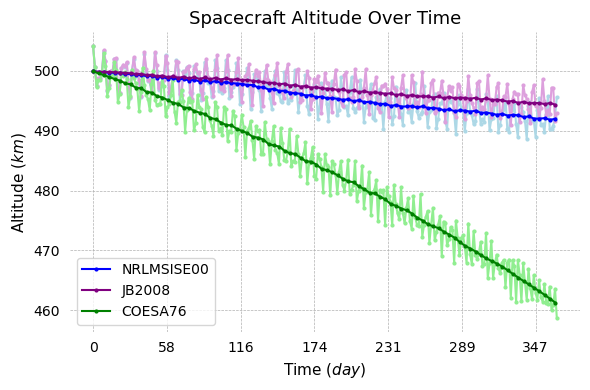

In [17]:
duration_sim = TimeDelta(times_nrl00[-1])
print(duration_sim)
x_label, x_label_f = find_x_scale(duration_sim)

steps = [100, 100, 100, 300, 300, 300]
labels = [
    "",
    "",
    "",
    r"NRLMSISE00",
    r"JB2008",
    r"COESA76",
]
colors = ["lightblue", "plum", "lightgreen", "blue", "purple", "green"]
xs = [
    times_nrl00,
    times_jb2008,
    times_coesa76,
    times_nrl00_f,
    times_jb2008_f,
    times_coesa76_f,
]
# the + 5 is a bit of cheating. it is because of the filter, i had to discard the first 20 data points
# so it appeared that the altitude was lower than that it is!
ys_altitudes = [
    altitudes_nrl00 + 5,
    altitudes_jb2008 + 5,
    altitudes_coesa76 + 5,
    altitudes_nrl00_f + 5,
    altitudes_jb2008_f + 5,
    altitudes_coesa76_f + 5,
]


plot_1d_multiple(
    xs,
    ys_altitudes,
    "Spacecraft Altitude Over Time",
    x_label,
    r"Altitude ($km$)",
    colors=colors,
    labels=labels,
    step=steps,
    fill_under=False,
    remove_box=True,
    show=True,
    x_label_f=x_label_f,
    save_filename=results_folder + "_altitude_comparison_1_year.jpg",
)

## Compare lifetime of satellite with JB2008 model, NRLMSISE00 model, and DRAMA

In [23]:
# DRAMA data
# path_DRAMA = "DRAMA_results/" + "500km_sa_not_cst_2"
# times_DRAMA = np.load(path_DRAMA + "_times.npy")
# altitudes_DRAMA = np.load(path_DRAMA + "_altitudes.npy")

path_DRAMA = "DRAMA_results/" + "500km_sa_not_cst_3"
times_DRAMA = np.load(path_DRAMA + "_times.npy")
altitudes_DRAMA = np.load(path_DRAMA + "_altitudes.npy")

# NRLMSISE00 data
path_simulation = "comparison_atmosphere_models_data/"
times_nrl00 = np.load(path_simulation + "times_lifetime_nrl00.npy")
altitudes_nrl00 = np.load(path_simulation + "altitude_lifetime_nrl00.npy")

# JB2008 data
times_jb2008 = np.load(path_simulation + "times_lifetime_jb2008.npy")
altitudes_jb2008 = np.load(path_simulation + "altitude_lifetime_jb2008.npy")

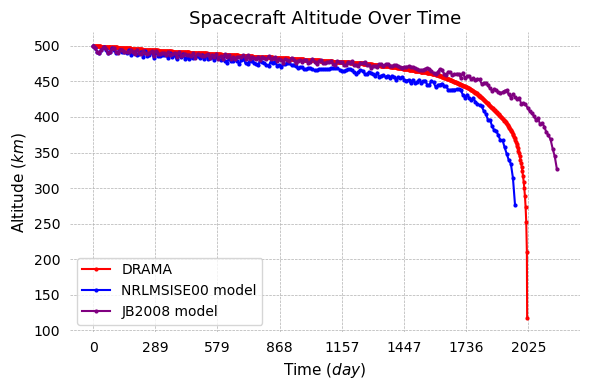

In [25]:
duration_sim_DRAMA = TimeDelta(times_DRAMA[-1])
duration_nrl00 = TimeDelta(times_nrl00[-1])
duration_jb2008 = TimeDelta(times_jb2008[-1])
duration = max(duration_nrl00, duration_jb2008, duration_sim_DRAMA)
x_label, x_label_f = find_x_scale(duration)

steps = [1, 700, 700]
labels = ["DRAMA", "NRLMSISE00 model", "JB2008 model"]
colors = ["red", "blue", "purple"]
xs = [times_DRAMA, times_nrl00, times_jb2008]
ys = [altitudes_DRAMA, altitudes_nrl00, altitudes_jb2008]

plot_1d_multiple(
    xs,
    ys,
    "Spacecraft Altitude Over Time",
    x_label,
    r"Altitude ($km$)",
    colors=colors,
    labels=labels,
    step=steps,
    fill_under=False,
    remove_box=True,
    show=True,
    x_label_f=x_label_f,
    save_filename=path_simulation + "lifetime_comparison.jpg",
)